<a href="https://colab.research.google.com/github/Yamashitast/DeepLearning2022Late/blob/main/Selenium%E3%81%A7%E7%94%BB%E5%83%8F%E5%8F%8E%E9%9B%862022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Seleniumを使って自動で画像検索し、結果を収集する

##必要なアプリのインストール
###Seleniumのインストール(バージョンを指定する)

In [ ]:
!pip install selenium==4.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 958 kB 5.0 MB/s 
     |████████████████████████████████| 384 kB 35.8 MB/s 
     |████████████████████████████████| 140 kB 49.7 MB/s 
     |████████████████████████████████| 57 kB 2.7 MB/s 
     |████████████████████████████████| 4.0 MB 40.4 MB/s 
     |████████████████████████████████| 58 kB 1.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.13 which is incompatible.


In [ ]:
!apt install chromium-chromedriver

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  chromium-browser chromium-browser-l10n chromium-codecs-ffmpeg-extra
Suggested packages:
  webaccounts-chromium-extension unity-chromium-extension
The following NEW packages will be installed:
  chromium-browser chromium-browser-l10n chromium-chromedriver
  chromium-codecs-ffmpeg-extra
0 upgraded, 4 newly installed, 0 to remove and 20 not upgraded.
Need to get 95.6 MB of archives.
After this operation, 321 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-codecs-ffmpeg-extra amd64 108.0.5359.71-0ubuntu0.18.04.5 [1,159 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-browser amd64 108.0.5359.71-0ubuntu0.18

##seleniumを実行して操作する

###その他のライブラリのimport

In [ ]:
import requests
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import os
import time
import datetime
#エラー処理用
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import ElementClickInterceptedException

/usr/local/lib/python3.8/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


##ログ用に時刻を取得

In [ ]:
tm_start=time.time()
dt_now=datetime.datetime.now()
dt_date_str=dt_now.strftime('%Y/%m/%d %H:%M')
print(dt_date_str)

2022/12/12 02:47


##検索に関する設定値を定義する

In [ ]:
QUERY='狐 フリー'#検索したいキーワード
LIMIT_DL_NUM=100#ダウンロード数の上限
SAVE_DIR='img/fox_'#出力フォルダ(自動生成させる)
FILE_NAME='dog_'#ファイル名(後ろに連番と拡張子をつけていく)
TIMEOUT=60#検索のタイムアウト(秒)
ACCESS_WAIT=1#アクセスする間隔(秒)←超重要
RETRY_NUM=3#クリックやrequestのリトライ回数
DRIVER_PATH='/usr/bin/chromedriver'#chromedriver.exeへのパス

##Chromeをヘッドレスモードで起動する
ヘッドレスモード=ブラウザを画面に開かないで実行するモード

In [ ]:
#optionの指定を準備
options=Options()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('start-fullscreen')
options.add_argument('--disable-plugins')
options.add_argument('--disable-extensions')
#起動する
driver=webdriver.Chrome(DRIVER_PATH,options=options)
driver.implicitly_wait(TIMEOUT)#タイムアウトを設定
#ログに処理時間を出力
tm_driver=time.time()
print('WebDriver起動完了',f'{tm_driver-tm_start:.1f}s')

<ipython-input-6-d474525bc3d9>:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver=webdriver.Chrome(DRIVER_PATH,options=options)


WebDriver起動完了 5.9s


##Googleの画像検索へのアクセス

In [ ]:
#QUERY条件付きでURLを定義する
url=f'https://www.google.com/search?q={QUERY}&tbm=isch'
#組み立てたURLでアクセスして検索
driver.get(url)
#時刻のログを取得
tm_geturl=time.time()
print('Google画像検索ページ取得',f'{tm_geturl-tm_driver:.1f}s')

Google画像検索ページ取得 3.9s


##検索結果の要素を取得していく

In [ ]:
#ページのサムネイル画像群を取得
#(islmpクラスが指定されたimg=サムネイルをすべて拾う)
tmb_elems=driver.find_elements_by_css_selector('#islmp img')
#サムネイルのリストから各サムネイルのalt属性を取得していく
tmb_alts=[tmb.get_attribute('alt') for tmb in tmb_elems]
#alt属性が空(小さいサムネイル)のものを差し引いて合計を算出
count=len(tmb_alts)-tmb_alts.count('')
print(count)

<ipython-input-8-2b7216ec13e1>:3: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  tmb_elems=driver.find_elements_by_css_selector('#islmp img')


48


##下にスクロールさせてさらに検索結果を表示させてまたカウント

In [ ]:
#定義したLIMIT_DL_NUM(ダウンロード数の上限)になるまでスクロールを繰り返す
while count<LIMIT_DL_NUM:
  #ページの一番下へスクロールして新しいサムネイル画像を表示させる
  driver.execute_script('window.scrollTo(0,document.body.scrollHeight);')
  time.sleep(1)#スリープを繰り返す間隔
  #(islmpクラスが指定されたimg=サムネイルをすべて拾う)
  tmb_elems=driver.find_elements_by_css_selector('#islmp img')
  #サムネイルのリストから各サムネイルのalt属性を取得していく
  tmb_alts=[tmb.get_attribute('alt') for tmb in tmb_elems]
  #alt属性が空(小さいサムネイル)のものを差し引いて合計を算出
  count=len(tmb_alts)-tmb_alts.count('')
  print(count)
#ループ終わり

<ipython-input-9-bac9a5ac2e39>:7: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  tmb_elems=driver.find_elements_by_css_selector('#islmp img')


100


##サムネイル画像をクリックすると右側に開かれる領域をオブジェクトに取得

In [ ]:
imgframe_elem=driver.find_element_by_id(('islsp'))

<ipython-input-10-4af9e03f6fd8>:1: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  imgframe_elem=driver.find_element_by_id(('islsp'))


###画像へURLアクセスして保存する準備をする

In [ ]:
#画像の保存フォルダを作成
os.makedirs(SAVE_DIR,exist_ok=True)
#HTTPリクエスト用のヘッダーを作る
HTTP_HEADERS={'User-Aget':driver.execute_script('return navigator.userAgent;')}
print(HTTP_HEADERS)
#ダウンロードしてきたい対象のファイル拡張子(extensios)
IMG_EXTS=('.jpg','.jpeg','.png','.gif')

{'User-Aget': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/108.0.5359.71 Safari/537.36'}


##ダウンロード中に利用する関数を定義する
画像の拡張子を取得する関数

In [ ]:
#拡張子を取得する関数
def get_extension(url):
  url_lower=url.lower()
  for img_ext in IMG_EXTS:#拡張子のリストから1つずつ比較
    if img_ext in url_lower:
      extension='.jpg' if img_ext=='.jpeg' else img_ext
      break
    #if終わり
    else:
      extension=''
  #for終わり
  return extension
#関数終わり

##urlで指定した画像へアクセスし、フォルダ内のファイルとして書き込む

In [ ]:
from requests.exceptions import RetryError
def download_image(url,path,loop):
  result=False#戻り値の変数
  for i in range(loop):
    try:
      r=requests.get(url,headers=HTTP_HEADERS,stream=True,timeout=10)
      r.raise_for_status()
      with open(path,'wb') as f:#バイナリ書き込みモードで開く
        f.write(r.content)
    except requests.exceptions.SSLError:
      print('****** SSL エラー')
      break#リトライしない
    except requests.exceptions.RequestException as e:
      print(f'****** requests エラー({e}):{i+1}/{RETRY_NUM}')
      time.sleep(1)
    else:
      result=True
      break#try成功
  #ループ終わり
#関数終わり

In [ ]:
###サムネイルを取得し、画像ダウンロードの準備ができたタイミング
tm_thumbnails=time.time()
print('サムネイル画像取得とDl準備完了',f'{tm_thumbnails-tm_geturl:.1f}s')

サムネイル画像取得とDl準備完了 20.8s


##ダウンロード処理

0:フリー写真] 座っているキツネでアハ体験 - GAHAG | 著作権フリー写真・イラスト素材集


/usr/local/lib/python3.8/dist-packages/selenium/webdriver/remote/webelement.py:484: UserWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  warnings.warn("find_element_by_* commands are deprecated. Please use find_element() instead")


***** urlチェック:1/3
***** urlチェック:2/3
***** urlチェック:3/3
***** urlに拡張子が含まれていないのでキャンセル

0:狐 狐 狐 狐 狐の写真素材 - ぱくたそ
***** urlチェック:1/3
***** urlチェック:2/3
***** urlチェック:3/3
***** urlに拡張子が含まれていないのでキャンセル

0:フリー写真] 眠りかけのキツネ - パブリックドメインQ：著作権フリー画像素材集
***** urlチェック:1/3
***** urlチェック:2/3
***** urlチェック:3/3
***** urlに拡張子が含まれていないのでキャンセル

0:画像素材なら！無料・フリー写真素材のフリーフォト
1:キツネの横顔の写真素材 - ぱくたそ
2:きつね村の写真素材｜写真素材なら「写真AC」無料（フリー）ダウンロードOK
3:フリー写真] 寝ているきつねでアハ体験 - GAHAG | 著作権フリー写真・イラスト素材集
***** urlチェック:1/3
***** urlチェック:2/3
***** urlチェック:3/3
***** urlに拡張子が含まれていないのでキャンセル

3:キツネ村の写真素材｜写真素材なら「写真AC」無料（フリー）ダウンロードOK
4:きたきつね 写真素材 [ 317558 ] 無料 - フォトライブラリー photolibrary
5:ホッキョクギツネ 狐 キツネのフリー素材・無料の写真 | 1920 x 1280| ピクト缶
6:狐」の商用利用可フリー写真素材一覧 | フォトック
7:狐のイラスト | かわいいフリー素材集 いらすとや
8:フリー画像|動物写真|哺乳類|イヌ科|狐/キツネ|画像素材なら！無料・フリー写真素材のフリーフォト
***** urlチェック:1/3
***** urlチェック:2/3
***** urlチェック:3/3
***** urlに拡張子が含まれていないのでキャンセル

8:狐（きつね/キツネ）のイラスト素材 | 商用可能な無料(フリー)のイラスト素材ならストックマテリアル
9:キツネ兄貴がかっこよすぎるのでフリーの画像を集めてみた【画像まとめ】│ジャングルタイムズ
10:フリー写真] キツネの横顔でアハ体験 - GAH
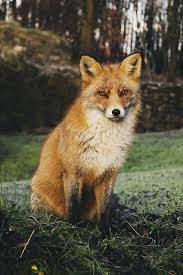
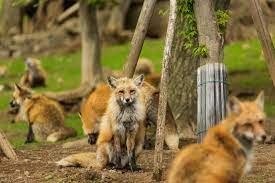
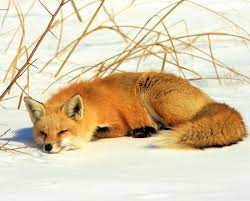
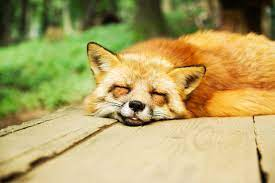
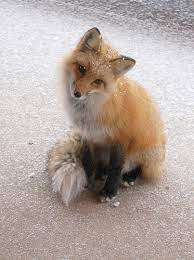
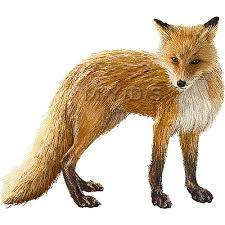

In [ ]:
EXCLUSION_URL='https//lh3.googleusercontent.com/'#除外対象URL
count=0
url_list=[]
#サムネイルをクリック、画像リンクを取得、画像をDL&保存を繰り返す
#zipで組合せの順番を固定化
for tmb_elem,tmb_alt in zip(tmb_elems,tmb_alts):
  if tmb_alt=='':#ALT属性が空=小さいサムネイルとみなしてスキップ
    continue
  print(f'{count}:{tmb_alt}')#カウンタとALT属性を表示
  #リトライ回数分だけ試行
  for i in range(RETRY_NUM):
    #サムネイルをクリック
    try:
      tmb_elem.click()
    except ElementClickInterceptedException:
      print(f'***** click エラー:{i+1}/{RETRY_NUM}')
      #フォーカスをあわせる
      driver.execute_script('arguments[0].scrollIntoView(true);',tmb_elem)
      time.sleep(1)
    else:
      break#try成功(クリック成功)
  #forの終わり
  else:
    print('***** キャンセル')
    continue#リトライ失敗、次のアイコンにスキップ
  #クリック成功したら、処理を続ける(画像のオブジェクトを取得する処理)
  time.sleep(ACCESS_WAIT)
  #alt属性の加工
  alt=tmb_alt.replace("'","\\")
  try:
    #左側のalt属性を基に左側の大きな画像をalt属性を指定して取得
    img_elem=imgframe_elem.find_element_by_css_selector(f'img[alt=\'{alt}\']')
  except NoSuchElementException:#右側に対応する要素が見つからない
    print('***** img要素検索エラー')
    print('***** キャンセル')
    continue#次のサムネイルへスキップ
  #右の大きな画像オブジェクトが取得出来たら、その画像リンクを取得する

  tmb_url=tmb_elem.get_attribute('src')#サムネイルsrc属性からリンクurlを取得
  #リトライしながらURLをチェック
  for i in range(RETRY_NUM):
    #大きい画像のURL
    url=img_elem.get_attribute('src')
    if EXCLUSION_URL in url:
      print('除外対象url')
      url=''
      break
    elif url==tmb_url:#サムネイルのurlと一緒なら、リトライを続ける
      print(f'***** urlチェック:{i+1}/{RETRY_NUM}')
    else:
      break#ループ中断(除外対象でもサムネイルでもない、OKなurl)
    #RETRYループ終わり
  #urlチェックの結果、OKなリンクでなければ次のサムネイルへスキップ
  if url=='':
    print('***** キャンセル')#大きなループをcontinue
    continue
  #url先の拡張子が指定の画像拡張子でなければ次のサムネイルへスキップ
  ext=get_extension(url)#自作の関数で拡張子を取得
  if ext=='':#指定の画像拡張子でない場合
    print(f'***** urlに拡張子が含まれていないのでキャンセル')
    print(f'{url}')
    continue
  
  #ダウンロード周り:保存するフォルダ
  filename=f'{FILE_NAME}{count}{ext}'
  path=SAVE_DIR+'/'+filename
  #ダウンロードを実行(自作関数を呼び出す)
  result=download_image(url,path,RETRY_NUM)
  if result==False:
    print('***** キャンセル')
    continue#次のサムネイルへスキップ
  #ダウンロードしたurlをリストに追加
  url_list.append(f'{filename}:{url}')

  #最後に、ダウンロード数カウンタの更新と終了判定
  count+=1
  if count>=LIMIT_DL_NUM:
    break#ダウンロードのループを終了
#ループの終了
#所領時間の表示
tm_end=time.time()#現在時刻
print('ダウンロード',f'{tm_end-tm_thumbnails:.1f}s')
print('------------------------')

##Colabo上へダウンロードしたファイルをzipで固めてローカルにダウンロードする

In [ ]:
#ここまでのトータル所要時間を出力する
total=tm_end-tm_start
total_str=f'トータル時間:{total:.1f}s({total/60:.2f}min)'
count_str=f'ダウンロード数:{count}'
print(total_str)
print(count_str)

トータル時間:222.5s(3.71min)
ダウンロード数:79


##Google検索してダウンロードした画像のURLもテキストに保存してローカルPCへダウンロードする

In [ ]:
#URLを書き込むテキストファイルの場所
DIR_TMP=SAVE_DIR+'/url/'
os.makedirs(DIR_TMP,exist_ok=True)
path=SAVE_DIR+'/url/'+'_url.txt'
with open(path,'w',encoding='utf-8') as f:
  f.write(dt_date_str+'\n')
  f.write(total_str+'\n')
  f.write(count_str+'\n')
  f.write('\n'.join(url_list))
  #openここまで
  driver.quit()#ブラウザを閉じる

##URLテキストと画像ファイルをローカルPCにダウンロード

In [ ]:
#ダウンロードしたフォルダをzpiに圧縮する
!zip -r /content/img_download.zip /content/img/
#圧縮したzipファイルをダウンロードする
from google.colab import files
files.download("/content/img_download.zip")

  adding: content/img/ (stored 0%)
  adding: content/img/fox_/ (stored 0%)
  adding: content/img/fox_/dog_28.jpg (deflated 1%)
  adding: content/img/fox_/dog_32.jpg (deflated 0%)
  adding: content/img/fox_/dog_78.jpg (deflated 1%)
  adding: content/img/fox_/dog_20.png (deflated 4%)
  adding: content/img/fox_/dog_15.jpg (deflated 6%)
  adding: content/img/fox_/dog_34.png (deflated 17%)
  adding: content/img/fox_/dog_8.png (deflated 3%)
  adding: content/img/fox_/dog_7.png (deflated 1%)
  adding: content/img/fox_/dog_3.jpg (deflated 0%)
  adding: content/img/fox_/dog_53.jpg (deflated 8%)
  adding: content/img/fox_/dog_40.jpg (deflated 0%)
  adding: content/img/fox_/dog_71.jpg (deflated 1%)
  adding: content/img/fox_/dog_12.png (deflated 2%)
  adding: content/img/fox_/dog_42.jpg (deflated 0%)
  adding: content/img/fox_/dog_27.jpg (deflated 0%)
  adding: content/img/fox_/dog_58.jpg (deflated 6%)
  adding: content/img/fox_/dog_33.jpg (deflated 10%)
  adding: content/img/fox_/dog_30.png (def

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>